Inspired/based on https://github.com/rayidghani/magicloops and https://github.com/dssg/MLforPublicPolicy/blob/master/labs/2019/lab6_feature_generation_sol.ipynb

In [1]:
import pipeline_v2 as pipeline
import importlib
import datetime
import pandas as pd
import numpy as np

# Read data

In [2]:
importlib.reload(pipeline)

datafile = "projects_2012_2013.csv"
data = pd.read_csv(datafile, parse_dates=['date_posted', 'datefullyfunded'])

# Explore data

Data exploration...

Number of rows: 124976

Columns and types of data:
projectid                                         object
teacher_acctid                                    object
schoolid                                          object
school_ncesid                                    float64
school_latitude                                  float64
school_longitude                                 float64
school_city                                       object
school_state                                      object
school_metro                                      object
school_district                                   object
school_county                                     object
school_charter                                    object
school_magnet                                     object
teacher_prefix                                    object
primary_focus_subject                             object
primary_focus_area                                object
secondary_focus_

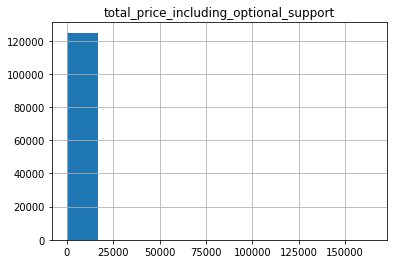

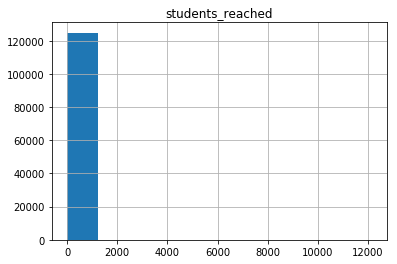

In [3]:
importlib.reload(pipeline)

stats_for_variables = [
  'total_price_including_optional_support',
  'students_reached'
]

variables_for_correlation = [
  'total_price_including_optional_support',
  'students_reached'
]

pipeline.explore_data(data, stats_for_variables, variables_for_correlation)

We can clearly see in the histograms that total_price_including_optional_support and students_reached have very big outliers.

# Create outcome label

In [4]:
importlib.reload(pipeline)

# The task is to predict if a project will not get fully funded within 60 days of posting.
data['duration_of_funding'] = data.datefullyfunded - data.date_posted
data['not_funded_in_60'] =  np.where(data['duration_of_funding']<=pd.Timedelta('60 days'), 1, 0)
output_label ='not_funded_in_60'

# Create features

In [5]:
#We will create binary features for categorical data, discretize features for contiuous data, and an aggregation feature

#Select columns from which we will create binary features. We use string string columns who have less than 50 different values (we dont want to generate too many binary values)
str_columns = [column for column in data.columns if data[column].dtype=='object' and len(data[column].unique())<51]

#Columns with float values to generate discrete features
float_columns = ['total_price_including_optional_support', 'students_reached']


In [6]:
importlib.reload(pipeline)

#Generate the binary features
features = pipeline.create_dummies(data[str_columns], str_columns)

#Genereate discretized features. Using qcut due to outliers (if not, almost all datapoints end up in 'low')
for float_column in float_columns:
  features[float_column] = pd.qcut(data[float_column], 5, labels=['low', 'medium low', 'medium', 'medium high', 'high'])
  
# Generate binary features for the new discretized columns
features = pipeline.create_dummies(features, float_columns)

In [7]:
#Aggregate feature: number of projects that got funded in the last 10 days. Idea: if many projects have been funded lately, this could be good info to predictor if a project will be funded soon

#List of all dates where projects have been posted
date_posted_list = pd.to_datetime(data['date_posted'].unique())

#We use a dictionary to save the amount of projects that have been funded within the last 10 days in each specific day
num_projects_funded_dict = {}

#For every possible date_posted
for date_posted in date_posted_list:
  #For each project, we calculate the difference between the current observed date and the project funded date
  #Lets remember that the difference between a value (date_posted) and a series (data['datefullyfunded']) is a series
  diff_date_and_fully_funded = date_posted - data['datefullyfunded']
  
  #Count how many projects have a difference between fully funded date and current date bigger than 0 and smaller or equal than 10
  amount_funded_in_last_10_days = np.sum((diff_date_and_fully_funded>pd.Timedelta('0 days')) & (diff_date_and_fully_funded<=pd.Timedelta('10 days')))
  
  #Save the amount in dictionary
  num_projects_funded_dict[date_posted.strftime("%Y%m%d")]= amount_funded_in_last_10_days

#We create the column to be attached, initially full of zeros for each row in the dataframe
num_of_projects_funded_10_days = np.zeros(len(data))
for index, row in data.iterrows():
  num_of_projects_funded_10_days[index] = num_projects_funded_dict[row['date_posted'].strftime("%Y%m%d")]

In [8]:
#Attach the created column to features
features['num_of_projects_funded_10_days']=num_of_projects_funded_10_days

# Create temporal train and test sets

In [9]:
importlib.reload(pipeline)
from dateutil.relativedelta import relativedelta

#Create three sets of train and test data, based on threee different split thresholds
split_thresholds = [pd.Timestamp(2013,7,1), pd.Timestamp(2013,1,1), pd.Timestamp(2012,7,1)]

#Indicating which is the column to be used for splitting training and test daata
date_column='date_posted'

#Amount of data used for test set
test_window = relativedelta(months=6)

#Gap needed between training and test set. 60 days in this case
gap_training_test = relativedelta(days=100)

#Generate train and test sets
train_test_sets= pipeline.create_temp_validation_train_and_testing_sets(
  data,
  features,
  date_column,
  output_label,
  split_thresholds,
  test_window,
  gap_training_test)

# Process data

In [10]:
importlib.reload(pipeline)

columns_to_process = [
  'total_price_including_optional_support',
  'students_reached'
]

# Build Clasifiers and parameters generation

In [11]:
importlib.reload(pipeline)

#We define the specific models we want to run
models_to_run=['LR', 'DT', 'AB','RF']#,'KNN']#,'BA','SVM']

#Get all posible models and their different sets of parameters
models, parameters_grid = pipeline.get_models_and_parameters()


# Loop over models and different training/test sets

In [12]:
importlib.reload(pipeline)

results = pipeline.iterate_over_models_and_training_test_sets(models_to_run, models, parameters_grid, train_test_sets)
results

Running LR with params: {'penalty': ['l1', 'l2'], 'C': [0.001, 0.1, 1, 10]} on train/test set 2013-07-01 00:00:00
Running DT with params: {'criterion': ['gini', 'entropy'], 'max_depth': [1, 5, 10, 50, 100], 'min_samples_split': [2, 5]} on train/test set 2013-07-01 00:00:00
Running AB with params: {'algorithm': ['SAMME', 'SAMME.R'], 'n_estimators': [1, 10, 100]} on train/test set 2013-07-01 00:00:00
Running RF with params: {'n_estimators': [10, 100], 'max_depth': [5, 50], 'max_features': ['sqrt', 'log2'], 'min_samples_split': [2, 10], 'n_jobs': [-1]} on train/test set 2013-07-01 00:00:00
Running LR with params: {'penalty': ['l1', 'l2'], 'C': [0.001, 0.1, 1, 10]} on train/test set 2013-01-01 00:00:00
Running DT with params: {'criterion': ['gini', 'entropy'], 'max_depth': [1, 5, 10, 50, 100], 'min_samples_split': [2, 5]} on train/test set 2013-01-01 00:00:00
Running AB with params: {'algorithm': ['SAMME', 'SAMME.R'], 'n_estimators': [1, 10, 100]} on train/test set 2013-01-01 00:00:00
Runn

,model_name,model,parameters,train_test_split_threshold,p_at_1,r_at_1,f1_at_1,p_at_2,r_at_2,f1_at_2,...,p_at_20,r_at_20,f1_at_20,p_at_30,r_at_30,f1_at_30,p_at_50,r_at_50,f1_at_50,auc-roc
0,LR,"LogisticRegression(C=10, class_weight=None, du...","{'C': 0.001, 'penalty': 'l1'}",2013-07-01,0.861678,0.012027,0.023723,0.840317,0.023485,0.045692,...,0.767689,0.214623,0.335461,0.756604,0.317297,0.447096,0.730653,0.510682,0.601177,0.537428
1,LR,"LogisticRegression(C=10, class_weight=None, du...","{'C': 0.001, 'penalty': 'l2'}",2013-07-01,0.934240,0.013040,0.025721,0.925255,0.025859,0.050311,...,0.858259,0.239943,0.375037,0.836906,0.350973,0.494548,0.799257,0.558633,0.657625,0.638292
2,LR,"LogisticRegression(C=10, class_weight=None, du...","{'C': 0.1, 'penalty': 'l1'}",2013-07-01,0.963719,0.013451,0.026533,0.966025,0.026998,0.052528,...,0.903204,0.252508,0.394677,0.874717,0.366830,0.516892,0.820224,0.573287,0.674876,0.673192
3,LR,"LogisticRegression(C=10, class_weight=None, du...","{'C': 0.1, 'penalty': 'l2'}",2013-07-01,0.959184,0.013388,0.026408,0.967157,0.027030,0.052589,...,0.899921,0.251590,0.393242,0.873208,0.366197,0.516000,0.820722,0.573635,0.675286,0.673600
4,LR,"LogisticRegression(C=10, class_weight=None, du...","{'C': 1, 'penalty': 'l1'}",2013-07-01,0.963719,0.013451,0.026533,0.960362,0.026840,0.052220,...,0.903770,0.252667,0.394924,0.875623,0.367210,0.517427,0.819997,0.573129,0.674690,0.672998
5,LR,"LogisticRegression(C=10, class_weight=None, du...","{'C': 1, 'penalty': 'l2'}",2013-07-01,0.963719,0.013451,0.026533,0.963760,0.026935,0.052405,...,0.903996,0.252730,0.395023,0.875170,0.367020,0.517159,0.819907,0.573065,0.674615,0.673964
6,LR,"LogisticRegression(C=10, class_weight=None, du...","{'C': 10, 'penalty': 'l1'}",2013-07-01,0.963719,0.013451,0.026533,0.960362,0.026840,0.052220,...,0.903544,0.252603,0.394825,0.875396,0.367115,0.517293,0.819997,0.573129,0.674690,0.672998
7,LR,"LogisticRegression(C=10, class_weight=None, du...","{'C': 10, 'penalty': 'l2'}",2013-07-01,0.959184,0.013388,0.026408,0.966025,0.026998,0.052528,...,0.899808,0.251559,0.393193,0.873962,0.366514,0.516446,0.820677,0.573603,0.675249,0.673729
8,DT,"DecisionTreeClassifier(class_weight=None, crit...","{'criterion': 'gini', 'max_depth': 1, 'min_sam...",2013-07-01,1.000000,0.013958,0.027532,1.000000,0.027947,0.054375,...,1.000000,0.279570,0.436974,1.000000,0.419370,0.590924,1.000000,0.698940,0.822795,0.579323
9,DT,"DecisionTreeClassifier(class_weight=None, crit...","{'criterion': 'gini', 'max_depth': 1, 'min_sam...",2013-07-01,1.000000,0.013958,0.027532,1.000000,0.027947,0.054375,...,1.000000,0.279570,0.436974,1.000000,0.419370,0.590924,1.000000,0.698940,0.822795,0.579323


<Figure size 432x288 with 0 Axes>

# Observe best models for each train/test set

## Ranking by AUC

In [13]:
#Lets obtain the best model for each train/test set

#indices of rows that have max auc for each train/test set
idx = results.groupby(['train_test_split_threshold'])['auc-roc'].transform(max) == results['auc-roc']

#display best models
best_auc = results[idx]
best_auc

,model_name,model,parameters,train_test_split_threshold,p_at_1,r_at_1,f1_at_1,p_at_2,r_at_2,f1_at_2,...,p_at_20,r_at_20,f1_at_20,p_at_30,r_at_30,f1_at_30,p_at_50,r_at_50,f1_at_50,auc-roc
33,AB,"(DecisionTreeClassifier(class_weight=None, cri...","{'algorithm': 'SAMME.R', 'n_estimators': 100}",2013-07-01,0.961451,0.013420,0.026470,0.959230,0.026808,0.052158,...,0.903996,0.252730,0.395023,0.874943,0.366925,0.517025,0.821084,0.573888,0.675584,0.674833
52,LR,"LogisticRegression(C=10, class_weight=None, du...","{'C': 0.1, 'penalty': 'l1'}",2013-01-01,0.948837,0.013796,0.027196,0.925754,0.026983,0.052438,...,0.876303,0.255833,0.396043,0.851274,0.372760,0.518484,0.800130,0.583959,0.675163,0.680477
104,LR,"LogisticRegression(C=10, class_weight=None, du...","{'C': 1, 'penalty': 'l1'}",2012-07-01,0.957317,0.012868,0.025395,0.963415,0.025901,0.050445,...,0.906502,0.243965,0.384461,0.876459,0.353838,0.504146,0.838358,0.564116,0.674424,0.665507


# Compare all models performance at different train/test sets

In [14]:
#For each model, find the set of parameters that work the best in each train/test set

#In this dataframe we will save the best model for each type of model (ex 1 LR, 1 RF..), whichever perfomed the best in each train/test set
best_models= pd.DataFrame()

for model in models_to_run:
  #Filter data selecting only rows of this specific model
  results_of_model = results[results["model_name"]==model]  
  #For each train/test set, find index of best model (parameters)
  idx = results_of_model.groupby(['train_test_split_threshold'])['auc-roc'].transform(max) == results_of_model['auc-roc']
    
  #Grab those results based on index
  best_model = results_of_model[idx]
  #Append it to final list
  best_models=best_models.append(best_model)

<Figure size 432x288 with 0 Axes>

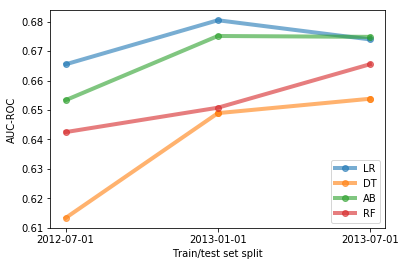

In [15]:
import matplotlib.pyplot as plt

#Clear plot
plt.clf()

#Create plot and axis
fig, ax1 = plt.subplots()

#Create lines for each model
for model in models_to_run:
  ax1.plot( 'train_test_split_threshold', 'auc-roc', data=best_models[best_models['model_name']==model], label=model, marker='o', markersize=6, linewidth=4,alpha=0.6)

#Show legends
plt.legend()

#Set axis labels
ax1.set_xlabel('Train/test set split')
ax1.set_ylabel('AUC-ROC',)

#Invert x_axis so as to show from earliest to latest
ax1.invert_xaxis()

plt.show()